Pyro Getting Started

### Notes

* stochastic functions often referred to as *models*.  They represent a process by which data is generated.
* *scoring a sample*: computing it's log probability.

Terminology

* **Primitive Stochastic Functions** - simple distributions.  Can compute the probability of the output given the input. 
* **Stochastic Functions** - callable objects with two things
   + some deterministic python code
   + a primitive stochastic function (or a distribution)
* **inference (in PPLs)** - Assume you have latent variables.  You're model works as follows `p(y,z | x)` where `z` is the latent variable. `y` is the observed output and `x` is the observed input.  You'd like to know the marginal `p(y|x)`.  It's not possible to compute this b/c you don't observe the latent variables.  *Inference in PPLs* is a way to construct the marginals by constraining one of the two elements of a stochastic function (the deterministic function or the underlying distribution). 
* **multivariable probability distributions** - distributions with more than one output variable.
* **importance sampling** - you're only interested in sampling from a section of one distribution but you have access to the full distribution only.  In this case you overweight samples from the important region. Also, when you sample from one distribution and use it to infer properties of a different distribution. 
* ** weighted execution traces ** - 
* ** guide functions ** - approximate posterior distributions that satisfy the following
    1. the guide and the model take the same arguments
    1. all unobserved `sample` statements that appear in the model also appear in the guide.
* ** stochastic variational inference ** - *Write me*


#### Core primitives

* `pyro.distribution`
* `pyro.sample`
* `pyro.condition`
* `pyro.infer.Marginal`
* `pyro.param`


Left off here 12/15:

http://pyro.ai/examples/svi_part_i.html

Left off here 12/7:

http://pyro.ai/examples/intro_part_ii.html#Parametrized-Stochastic-Functions-and-Variational-Inference


Left off here:  

> The real utility of probabilistic programming is in the ability to condition generative models on observed data and infer the latent factors that might have produced that data. 

http://pyro.ai/examples/intro_part_ii.html

Unpack the above statement.  Remind yourself what a generative model is.  Why do you care about infering the latent factors?

In [2]:
import torch
from torch.autograd import Variable

import pyro
import pyro.distributions as dist

%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt

In [3]:

mu = Variable(torch.zeros(1)); mu

Variable containing:
 0
[torch.FloatTensor of size 1]

In [4]:
mu.size() # like shape


torch.Size([1])

In [5]:
mu = Variable(torch.zeros(10))
sigma = Variable(torch.ones(10)) # unit variance
x = dist.normal(mu, sigma); x


Variable containing:
 0.6199
 1.3305
 0.8724
-0.7519
 0.6428
-0.4585
-0.3839
-0.1910
-0.5843
 1.2454
[torch.FloatTensor of size 10]

In [6]:
x = dist.normal(mu, sigma); x


Variable containing:
 0.1841
-0.2631
-0.9543
-1.8935
 0.3725
-0.9948
 0.2347
-0.3415
-0.8843
 0.2481
[torch.FloatTensor of size 10]

In [7]:
x = dist.normal(mu, sigma+10); x #broadcasting with regular int. 

Variable containing:
  1.2928
  2.6644
 -4.1717
  9.7181
-20.6915
 12.8412
  2.3168
  3.0788
  7.8327
-12.1008
[torch.FloatTensor of size 10]

In [8]:
log_p_x = dist.normal.log_pdf(x, mu, sigma)


In [9]:
log_p_x #looks like it summed 10 variables before taking the log prob.

Variable containing:
-490.4719
[torch.FloatTensor of size 1]

In [9]:
x = dist.normal(Variable(torch.zeros(1)),Variable(torch.ones(1)))
lpx = dist.normal.log_pdf(x, Variable(torch.zeros(1)),Variable(torch.ones(1))); lpx

Variable containing:
-1.1612
[torch.FloatTensor of size 1]

In [10]:
#get a named sample. 
x = pyro.sample("my_sample", dist.normal, mu, sigma)
x.data[0] #how you get the data back.

-1.2076796293258667

In [12]:
x

Variable containing:
-1.2077
-0.4632
 1.0278
-0.5523
-1.6599
-0.8961
 0.6391
-1.6604
 1.1034
-0.4553
[torch.FloatTensor of size 10]

In [13]:
#here's a recursive function that randomly terminates it's recursion.

def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), dist.bernoulli, p)
    if torch.equal(x.data, torch.zeros(1)):
        return x
    else:
        return x + geometric(p, t+1)

print(geometric(Variable(torch.Tensor([0.8])))) #will recurse with probability 0.8

Variable containing:
 5
[torch.FloatTensor of size 1]



### Importance Sampling

Using importance sampling to construct a posterior

In [4]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))  #latent variable
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))  #output.

In [5]:
posterior = pyro.infer.Importance(scale, num_samples=100) #generating data here?

#'weight' is the latent parameter
#'marginal' gives you a histogram and same for the observed variable 'measurement'.

marginal = pyro.infer.Marginal(posterior)

Marginal will do the following:

* get execution traces from `posterior` given the data `guess`
* build a histogram from those traces
* returns a sample from the histogram

This reminds me of bayesian inference. 

In [39]:
guess = Variable(torch.Tensor([8.5]))
marginal(guess)

Variable containing:
 9.2681
[torch.FloatTensor of size 1]

In [12]:
guess = Variable(torch.Tensor([1., 2., 10.]))

In [ ]:
#won't work with three inputs.
#marginal(guess)

### Marginal Distributions

* stochastic functions induce a joint probability distribution over output and latent variables given inputs.
* The joint distribution mentioned above induces a marginal distribution over the function's return values.
* You can't sample directly from the marginal distribution.  **Why not**

In the stochastic function `scale`, `guess` is the input, `measurement` is the output and `weight` is the latent variable. 

Notes:

* "induced probability space" - http://answers.google.com/answers/threadview/id/537046.html

### Conditioning Models on Data

* Separate conditioning and inference
* 

In [14]:
### Stochastic Variational Inference Example

In [13]:
guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})



In [14]:
conditioned_scale(guess)

#you told it what the measurement was so it's going to always return the same value.

Variable containing:
 9.5000
[torch.FloatTensor of size 1]

In [17]:
weight = Variable(torch.Tensor([7.0]))
cond_weight_scale = pyro.condition(scale, data={"weight": weight})
cond_weight_scale(guess)

Variable containing:
 7.0611
[torch.FloatTensor of size 1]

### Guide Functions

* any `pyro.sample` variables you define in original stochastic function that you do not condition on must be present in the guide function (i.e. defined with `pyro.sample` and have the same name).
* you want to choose a guide such that it closely approximates the `pyro.sample` variables in the model that are "unobserved" (i.e. that you're not conditioning on).

How does `pyro.param` help you look through a *family of distributions* to find the one that best approximates the posterior?


In [18]:
#guide function for the prior "guess". 
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1))) #new weight param used in guide.  matches up with 'weight' param in stochastic function. 

#sample from one distribution using another.
posterior = pyro.infer.Importance(conditioned_scale,  #scale function conditioned on observed 'measurement'
                                  guide=scale_prior_guide,
                                  num_samples=10)

#find out about latent variable. 
marginal = pyro.infer.Marginal(posterior, sites=["weight"])
#guess = Variable(torch.Tensor([8.5]))
marginal(guess)

{'weight': Variable containing:
  10.2071
 [torch.FloatTensor of size 1]}

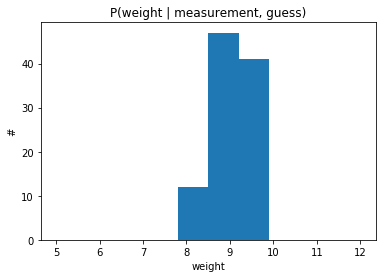

In [25]:
#Better to use the posterior as a guide.  Note: now we're conditioning on both measurement and guess.  

def conditioned_scale2(measurement, guess):
    cscale = pyro.condition(scale, data={"measurement": measurement})
    return cscale(guess)

def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.normal, a, b)

#remember that conditional_scale conditions on measurement. 
posterior = pyro.infer.Importance(conditioned_scale2,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.Marginal(posterior, sites=['weight'])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")


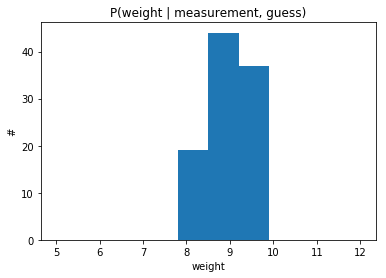

In [21]:

def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)

def scale_posterior_guide(measurement, guess):
    # note that torch.size(measurement, 0) is the total number of measurements
    # that we're conditioning on
    a = (guess + torch.sum(measurement)) / (measurement.size(0) + 1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0) + 1.0)
    return pyro.sample("weight", dist.normal, a, b)

posterior = pyro.infer.Importance(deferred_conditioned_scale,
                                  guide=scale_posterior_guide,
                                  num_samples=20)

marginal = pyro.infer.Marginal(posterior, sites=["weight"])
plt.hist([marginal(measurement, guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

In [26]:
marginal(Variable(torch.Tensor([8.5])), Variable(torch.Tensor([8.5])))

{'weight': Variable containing:
  9.0270
 [torch.FloatTensor of size 1]}

#### Parameterized Guides

If you use parameters in your guide function you can pass it to stochastic variational inference (svi) function that will set the optimal parameters of your guide function. Once this is done you can **use the guide as an approximate posterior**

One the guide's parameters have been set you can reuse it with `Importance` and `Marginal` to get a marginal distribution over observed or latent variables. 

In [17]:

def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))



In [24]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss="ELBO")

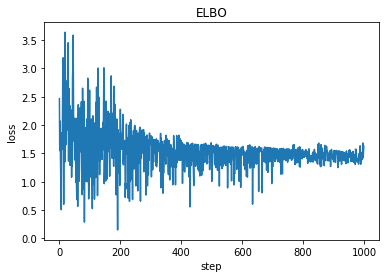

In [25]:
losses = []
for t in range(1000):
    losses.append(svi.step(guess)) #give the function the same guess many, many times. In reality you'd give it whatever data you'd observed here.

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [27]:
scale_parametrized_guide

<function __main__.scale_parametrized_guide>

In [31]:
pyro.param('a'), pyro.param('b')  #parameters of our approximate posterior. 

(Variable containing:
  9.0900
 [torch.FloatTensor of size 1], Variable containing:
  0.5918
 [torch.FloatTensor of size 1])

In [33]:
scale_parametrized_guide(guess) #sampling from our approximate posterior (given)

Variable containing:
 9.6743
[torch.FloatTensor of size 1]

In [34]:
#or use our guide as an importance distribution to estimate the marginal distribution. 
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

marginal(guess)

{'weight': Variable containing:
  9.5961
 [torch.FloatTensor of size 1]}

Left off here:

* http://pyro.ai/examples/svi_part_i.html